In [1]:
import pandas as pd
import regex as re
import numpy as np

In [2]:
data = pd.read_csv("data/keywords.csv")

In [26]:
data["keywords_nan"] = data["keywords"].replace("[]", np.nan)

In [3]:
data.iloc[[0]].keywords[0]

"[{'id': 931, 'name': 'jealousy'}, {'id': 4290, 'name': 'toy'}, {'id': 5202, 'name': 'boy'}, {'id': 6054, 'name': 'friendship'}, {'id': 9713, 'name': 'friends'}, {'id': 9823, 'name': 'rivalry'}, {'id': 165503, 'name': 'boy next door'}, {'id': 170722, 'name': 'new toy'}, {'id': 187065, 'name': 'toy comes to life'}]"

In [27]:
def key_word_grabber(text):
    
    if text is not np.nan:
        
        return re.findall(r"'name':\s*'([^']*)'", text)
    else:
        return text

In [28]:
data["keywords_list"] = data["keywords_nan"].apply(lambda x: key_word_grabber(x))

In [31]:
data["keywords_nan"].isna().sum()

14795

In [32]:
data.shape

(46419, 4)

In [29]:
data["keywords_list"]

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, new home, recluse,...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
46414                                        [tragic love]
46415                                [artist, play, pinoy]
46416                                                  NaN
46417                                                  NaN
46418                                                  NaN
Name: keywords_list, Length: 46419, dtype: object

In [6]:
data.shape

(46419, 3)

In [7]:
data["keywords"].value_counts()

[]                                                                                                                                                                                                                             14795
[{'id': 187056, 'name': 'woman director'}]                                                                                                                                                                                      1323
[{'id': 10183, 'name': 'independent film'}]                                                                                                                                                                                      509
[{'id': 9716, 'name': 'stand-up comedy'}]                                                                                                                                                                                        235
[{'id': 4344, 'name': 'musical'}]                                                   

In [8]:
type(data.iloc[46418]["keywords_list"])

list

In [9]:
data["keywords_list"].apply(lambda x: x)

0        [jealousy, toy, boy, friendship, friends, riva...
1        [board game, disappearance, new home, recluse,...
2        [fishing, best friend, duringcreditsstinger, o...
3        [based on novel, interracial relationship, sin...
4        [baby, midlife crisis, confidence, aging, daug...
                               ...                        
46414                                        [tragic love]
46415                                [artist, play, pinoy]
46416                                                   []
46417                                                   []
46418                                                   []
Name: keywords_list, Length: 46419, dtype: object

In [74]:
data2 = pd.read_csv("data/movies_metadata.csv")

/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [41]:
data2.drop(data2.loc[data2['overview']=="No overview found."].index, inplace=True)

In [37]:
data2.drop(data2.loc[data2['overview']=="No Overview"].index, inplace=True)

In [38]:
data2.drop(data2.loc[data2['overview']==""].index, inplace=True)

In [39]:
data2.drop(data2.loc[data2['overview']=="No movie overview available"].index, inplace=True)

In [63]:
def parse_overview(text):
    
    if text is not np.nan:
        
        if len(text) < 20:
            return np.nan
        else:
            return text
    

In [75]:
data2["overview_filtered"] = data2["overview"].apply(lambda x: parse_overview(x))

In [76]:
data2 = data2[data2["overview_filtered"].notna()]

In [86]:
data = data.drop(columns=["keywords_nan"])

In [94]:
data2["id"] = data2["id"].astype(int)

/var/folders/34/1yvhb8vj085g3m5tpn1x91d80000gn/T/ipykernel_72364/862761141.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2["id"]=data2["id"].astype(int)


In [96]:
full_data = data2.merge(data, on="id", how="left")

In [71]:
data.sort_values(by="tmpp", key=lambda x: x.str.len()).head(30)

,id,keywords,keywords_list,keywords_nan,tmpp
21818,91745,"[{'id': 497, 'name': 'shakespeare'}, {'id': 13...","[shakespeare, teenager, middle ages, family fe...","[{'id': 497, 'name': 'shakespeare'}, {'id': 13...",Film by Risto Jarva.
20301,84328,[],NaN,NaN,American Documentary
35326,351819,"[{'id': 572, 'name': 'sex'}, {'id': 9215, 'nam...","[sex, black, parody, spoof, millionaire]","[{'id': 572, 'name': 'sex'}, {'id': 9215, 'nam...",Finnish documentary.
31468,87884,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[female nudity, teacher]","[{'id': 293, 'name': 'female nudity'}, {'id': ...",Based on true events
30334,13803,"[{'id': 12663, 'name': 'little girl'}, {'id': ...","[little girl, killer]","[{'id': 12663, 'name': 'little girl'}, {'id': ...",For a Book of Dollars
34664,337751,"[{'id': 9073, 'name': 'marilyn monroe'}, {'id'...","[marilyn monroe, woman director]","[{'id': 9073, 'name': 'marilyn monroe'}, {'id'...",Standup in Las Vegas.
43368,435351,"[{'id': 9716, 'name': 'stand-up comedy'}]",[stand-up comedy],"[{'id': 9716, 'name': 'stand-up comedy'}]",A journey into night.
22078,15991,"[{'id': 293, 'name': 'female nudity'}, {'id': ...","[female nudity, orgasm]","[{'id': 293, 'name': 'female nudity'}, {'id': ...",A film by Jari Halonen
27491,171292,"[{'id': 174878, 'name': 'female vampire'}]",[female vampire],"[{'id': 174878, 'name': 'female vampire'}]",A man dances on curbs.
43931,255552,"[{'id': 380, 'name': 'brother brother relation...","[brother brother relationship, family, missing...","[{'id': 380, 'name': 'brother brother relation...",Love on the front page


In [2]:
import spacy

In [13]:
#!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.1 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [99]:
nlp = spacy.load('en_core_web_md')

In [114]:
valid_POS = set(['VERB', 'NOUN', 'ADJ', 'PROPN'])
specific_stw = set(['relevant', 'simple', 'base'])

def text_preprocessing(rawtext):
    #Sentence tokenization and filtering of non-English sentences
    #mult_doc = mult_nlp(rawtext)
    #english_text = ' '.join([sent.text for sent in mult_doc.sents if sent._.language['language']=='en'])

    #Tokenization
    english_doc = nlp(rawtext)

    new_tokens = list()

    for token in english_doc:
        # POS
        if token.pos_ not in valid_POS:
            continue
        
        # alphanumeric
        if not token.is_alpha:
            continue

        # stopwords
        if token.is_stop or token.text in specific_stw:
            continue

        new_tokens.append(token)

    # Lemmatization
    lemmatized_text = ' '.join([token.lemma_ for token in new_tokens])
    return lemmatized_text

In [2]:
full_data["preprocessed_overview"] = full_data["overview_filtered"].apply(lambda x: text_preprocessing(x))

NameError: name 'full_data' is not defined

In [3]:
import pandas as pd
import numpy as np

In [4]:
full_data = pd.read_csv("data/full_data_2_index.csv")

/Users/nicolas/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
corpus = [row["overview_plus_keyword_preprocessed"].split() for idx, row in full_data.iterrows()]

In [6]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)

In [7]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print('============= Review (lemmas) =============')
print(' '.join(corpus[n_review]))

print('\n============= Sparse vector representation =============')
print(reviews_bow[n_review])

print('\n============= Word counts for the review =============')
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
Pennsylvania band score hit ride star make machinery lot help managerpop star musical record label music music band

============= Sparse vector representation =============
[(397, 2), (775, 2), (841, 1), (1184, 1), (1339, 2), (1347, 1), (1369, 1), (1868, 1), (2491, 1), (2893, 1), (3903, 1), (8268, 1), (9874, 1), (9875, 1), (9876, 1)]

============= Word counts for the review =============
[('star', 2), ('music', 2), ('help', 1), ('musical', 1), ('band', 2), ('hit', 1), ('make', 1), ('lot', 1), ('record', 1), ('ride', 1), ('Pennsylvania', 1), ('score', 1), ('label', 1), ('machinery', 1), ('managerpop', 1)]


In [8]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow)

In [9]:
reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print('============= TFIDF representation for the project =============')
print(reviews_tfidf[n_review])

print('\n============= TFIDF applying the transformation only to the document =============')
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(397, 0.264267707321308), (775, 0.3104867414112983), (841, 0.11613629374185341), (1184, 0.1640775929540695), (1339, 0.33825516549337775), (1347, 0.17088238878104284), (1369, 0.13939061927576854), (1868, 0.19980231073721513), (2491, 0.19453440924232138), (2893, 0.1860596567971478), (3903, 0.28468200270517907), (8268, 0.22838600979516144), (9874, 0.28056370613837767), (9875, 0.32782159403704136), (9876, 0.44557218946490545)]

============= TFIDF applying the transformation only to the document =============
[(397, 0.264267707321308), (775, 0.3104867414112983), (841, 0.11613629374185341), (1184, 0.1640775929540695), (1339, 0.33825516549337775), (1347, 0.17088238878104284), (1369, 0.13939061927576854), (1868, 0.19980231073721513), (2491, 0.19453440924232138), (2893, 0.1860596567971478), (3903, 0.28468200270517907), (8268, 0.22838600979516144), (9874, 0.28056370613837767), (9875, 0.32782159403704136), (9876, 0.445572189464905

In [147]:
" ".join(full_data.iloc[0]["keywords_list"])

'jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life'

In [150]:
full_data["keywords_list"] = full_data["keywords_list"].apply(lambda x: " ".join(x) if x is not np.nan else x)

In [154]:
full_data["preprocessed_keywords"] = full_data["keywords_list"].apply(lambda x: text_preprocessing(x) if x is not np.nan else x)

In [155]:
full_data["preprocessed_keywords"]

0        jealousy toy boy friendship friend rivalry boy...
1        board game disappearance new home recluse gian...
2            fish good friend duringcreditsstinger old man
3        base novel interracial relationship single mot...
4        baby midlife crisis confidence age daughter mo...
                               ...                        
45291                                          tragic love
45292                                    artist play pinoy
45293                                                  NaN
45294                                                  NaN
45295                                                  NaN
Name: preprocessed_keywords, Length: 45296, dtype: object

In [176]:
full_data["preprocessed_keywords_nan_as_string"] = full_data.preprocessed_keywords.fillna('')

In [179]:
full_data["overview_plus_keyword_preprocessed"] = full_data["preprocessed_overview"] + full_data["preprocessed_keywords_nan_as_string"]

In [10]:
# create feature and target dataframes
X = full_data[["overview_plus_keyword_preprocessed"]]
y = full_data["vote_average"]

In [11]:
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, 
                                                    random_state = 21, shuffle = True)

In [12]:
X_train

,overview_plus_keyword_preprocessed
35228,year old cycling talent Freddy son butcher idy...
13737,overweight loner Rino spend day seclusion dad ...
34687,Raggedy Ann Andy leave playroom rescue Babette...
30067,Zenon Kar teenager live space station year com...
32779,orphan young age Scriptwriter Amit military pi...
...,...
16432,Caitlin Fairchild teenager offer place institu...
8964,busload woman strand isolated canadian country...
5944,Monty Python live Hollywood Bowl concert film ...
5327,beautiful sophisticated woman Oscar Grubman se...


In [13]:
from tensorflow.keras.preprocessing.text import text_to_word_sequence 

# sequence words
# X_train_seq is a list with each element being a list of each word in one article as a separate string

X_train_seq = [text_to_word_sequence(zz) for zz in X_train["overview_plus_keyword_preprocessed"]]
X_test_seq = [text_to_word_sequence(zz) for zz in X_test["overview_plus_keyword_preprocessed"]]

2023-05-02 10:12:58.932524: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
%%time
from gensim.models import Word2Vec

# dimensions of vector embedding
dim_embedding = 100

# create Word2Vec on Train set
w2v = Word2Vec(sentences = X_train_seq, vector_size = dim_embedding, window = 5, min_count = 1)

CPU times: user 12 s, sys: 116 ms, total: 12.1 s
Wall time: 5.22 s


In [22]:
w2v.save("data/first_mode.model")

# This function will load the model, but we will not be using it here
#model_w2v = Word2Vec.load("model_w2v_imbd_sampling03.model")

In [23]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = w2v.wv
word_vectors.save("data/model_w2v_imbd_sampling03.wordvectors")

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("data/model_w2v_imbd_sampling03.wordvectors", mmap='r')

In [17]:
from termcolor import colored

In [24]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(w2v.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['film', 'life', 'man', 'find', 'young', 'woman', 'love', 'new', 'year', 'family', 'story', 'world', 'friend', 'old', 'director', 'war', 'time', 'murder', 'father', 'girl', 'live', 'take', 'come', 'relationship', 'try', 'day', 'school', 'work', 'wife', 'meet', 'mother', 'town', 'fall', 'child', 'set', 'death', 'help', 'go', 'son', 'daughter', 'turn', 'base', 'leave', 'movie', 'way', 'brother', 'discover', 'begin', 'good', 'police']

============= Embedding of the first word =============
[-0.7157931   0.75939924  1.8496125   0.5863084  -2.287857   -2.1597025
  1.3608464   2.3676326  -1.2609     -1.1617873  -0.40795526 -1.8466314
 -0.8489243   1.0812337  -0.95487547 -0.30958056  0.22705288 -0.61777854
 -2.1351156  -2.5458891   1.3007383  -0.04242763  1.8753295   0.83131033
 -0.11799303 -0.9668827  -1.0727235   0.21619782 -1.1617885  -0.41672447
 -1.7930467  -0.2132017   2.55171    -1.5263268   0.3371798   0.6294545
  2.618899    0.0150114

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(init='random')
embed_tsne = tsne.fit_transform(wv.vectors)

# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

NameError: name 'plt' is not defined

In [29]:
import pickle

In [35]:
pkl = "embed_tsne.pkl"

with open(pkl, "wb") as file:
    pickle.dump(embed_tsne, file)

In [36]:
with open(pkl, "rb") as file:
    model = pickle.load(file)

In [37]:
model

array([[ 30.581177 ,  21.624704 ],
       [ 30.387545 ,  13.202191 ],
       [ 30.78999  ,  11.737264 ],
       ...,
       [-12.139985 ,   9.433384 ],
       [-11.164126 ,   2.3530734],
       [ 18.275745 ,  -5.8071237]], dtype=float32)

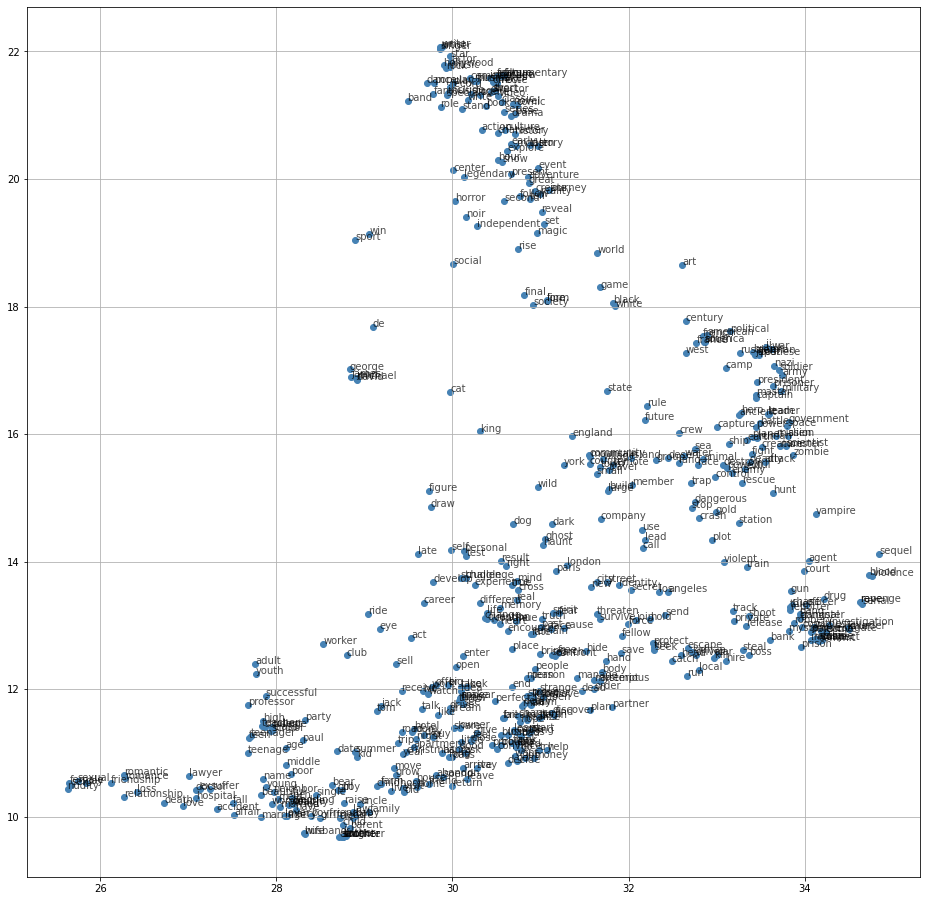

In [28]:
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(word, (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)
      
plt.grid()

In [26]:
import matplotlib.pyplot as plt

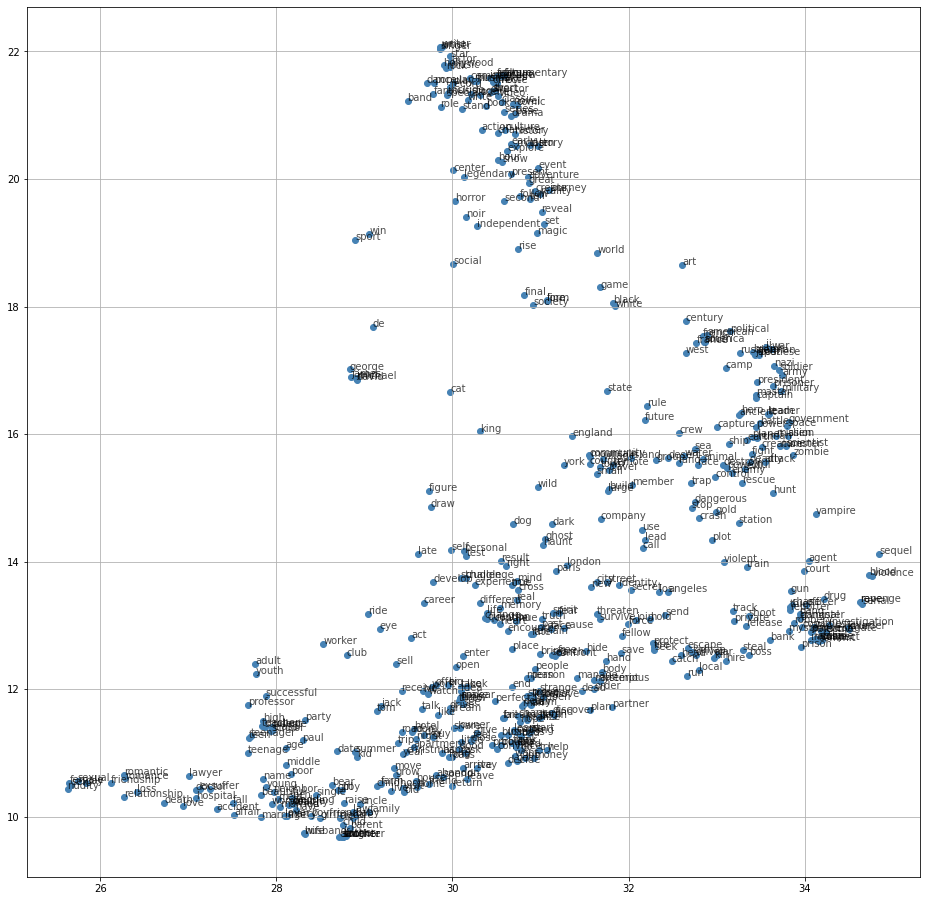

In [38]:
# We plot only 500 embeddings
fig, ax = plt.subplots(figsize=(16, 16))
for idx, word in enumerate((list(wv.key_to_index.keys())[:500])):
    plt.scatter(*model[idx, :], color='steelblue')
    plt.annotate(word, (model[idx, 0], model[idx, 1]), alpha=0.7)
      
plt.grid()

In [ ]:
def get_vocabulary_coverage(model, gensim_dict):
  coverage = len(model)/len(gensim_dict)
  return coverage

# <SOL>
print(get_vocabulary_coverage(wv, D))
# </SOL>